# KNN으로 포지션 예측하기

In [90]:
# Random값을 정하기
import numpy as np
np.random.seed(5)

In [91]:
import pandas as pd

In [92]:
train = pd.read_csv("../Data/basketball_train.csv")
test = pd.read_csv("../Data/basketbal_test.csv")

In [93]:
train.head()

,Player,Pos,3P,TRB,BLK
0,Denzel Valentine,SG,1.3,2.6,0.1
1,Garrett Temple,SG,1.3,2.8,0.4
2,Danny Green,SG,1.7,3.3,0.8
3,Rodney Hood,SG,1.9,3.4,0.2
4,Tristan Thompson,C,0.0,9.2,1.1


In [94]:
test.head()

,Player,Pos,3P,TRB,BLK
0,Buddy Hield,SG,1.8,3.3,0.1
1,Jamal Murray,SG,1.4,2.6,0.3
2,Dwyane Wade,SG,0.8,4.5,0.7
3,Zach LaVine,SG,2.6,3.4,0.2
4,Al Horford,C,1.3,6.8,1.3


In [95]:
print(train.shape)
print(train.count())
print(train.isnull().sum())

(80, 5)
Player    80
Pos       80
3P        80
TRB       80
BLK       80
dtype: int64
Player    0
Pos       0
3P        0
TRB       0
BLK       0
dtype: int64


In [96]:
print(test.shape)
print(test.count())
print(test.isnull().sum())

(20, 5)
Player    20
Pos       20
3P        20
TRB       20
BLK       20
dtype: int64
Player    0
Pos       0
3P        0
TRB       0
BLK       0
dtype: int64


### 최적의 k 찾기 (교차검증 - cross validation)

In [97]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score # 교차검증

In [98]:
# 최적의 k를 찾기 위해 교차 검증을 수행할 k의 점위를 3부터 학습데이터의 절반까지 지정
max_k_range = train.shape[0] // 2 # 나누기의 몫만 출력
max_k_range

40

In [99]:
# 최적의 k를 찾기 위해 범위 확인
k_list = []
for i in range(3,max_k_range,2):
    k_list.append(i)
k_list 

[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39]

In [100]:
# 점수 저장 및 Train Data 정의
cross_validation_scores = []
x_train = train[['3P','BLK','TRB']]
y_train = train['Pos']

print(x_train.head())
print(y_train.head())

    3P  BLK  TRB
0  1.3  0.1  2.6
1  1.3  0.4  2.8
2  1.7  0.8  3.3
3  1.9  0.2  3.4
4  0.0  1.1  9.2
0    SG
1    SG
2    SG
3    SG
4     C
Name: Pos, dtype: object


---

In [101]:
# 교차검증(10-fold)을 각 k를 대상으로 수행해 검증 결과를 저장

for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(
        knn,
        x_train,
        y_train,
        cv=10, # cv: cross validation(교차검증 횟수)
        scoring='accuracy'
    )
    cross_validation_scores.append(scores.mean())
cross_validation_scores


[0.9375,
 0.9375,
 0.9375,
 0.925,
 0.95,
 0.95,
 0.9375,
 0.9375,
 0.925,
 0.925,
 0.9125,
 0.9125,
 0.9125,
 0.9,
 0.8875,
 0.8875,
 0.8875,
 0.8875,
 0.875]

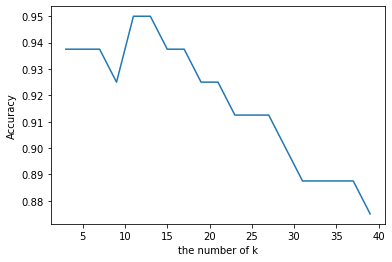

In [102]:
# k에 따른 정확도를 시각화
import matplotlib.pyplot as plt

plt.plot(k_list,cross_validation_scores)
plt.xlabel('the number of k')
plt.ylabel('Accuracy')
plt.show()

In [103]:
# 가장 예측율이 높은 k를 선정
cvs = cross_validation_scores
k= k_list[cvs.index(max(cross_validation_scores))]
print("The best number of k is",k)

The best number of k is 11


---
### 2개의 특징으로 예측하기(3점슛, 블로킹)

In [104]:
from sklearn.neighbors import KNeighborsClassifier

In [105]:
knn = KNeighborsClassifier(n_neighbors=k)

In [106]:
# 학습에 사용할 features
x_train = train[['3P','BLK']]

In [107]:
# 학습에 사용할 target
y_train = train['Pos']

In [108]:
# 학습 시키기
knn.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=11)

In [109]:
# 검증에 사용할 features
x_test = test[['3P',"BLK"]]

In [110]:
# 검증의 정답
y_test = test['Pos']

In [111]:
knn.score(x_test,y_test)

0.9

In [112]:
# 예측
pred = knn.predict(x_test)
pred

array(['SG', 'SG', 'SG', 'SG', 'C', 'SG', 'C', 'C', 'SG', 'SG', 'SG',
       'SG', 'C', 'SG', 'C', 'C', 'C', 'C', 'SG', 'SG'], dtype=object)

In [116]:
# 실제값과 예측값의 비교
comparsion = pd.DataFrame(
    {'예측값':pred,
    '정답':y_test
    }
)
comparsion.head()

,예측값,정답
0,SG,SG
1,SG,SG
2,SG,SG
3,SG,SG
4,C,C


### Confusion matrix

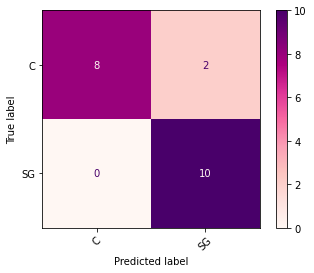

In [120]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

confusion_matrix1 = confusion_matrix(y_test,pred)
target_names = ["C","SG"]
disp = ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix1,
    display_labels = target_names
)
disp.plot(
    cmap=plt.cm.RdPu,
    xticks_rotation=45
)
plt.show()

---
### 3개의 특징으로 예측하기(3점슛,블로킹,리바운드)

In [121]:
knn = KNeighborsClassifier(n_neighbors=k)

In [122]:
x_train1 = train[['3P','BLK','TRB']]
y_train1 = train['Pos']

In [123]:
knn.fit(x_train1,y_train1)

KNeighborsClassifier(n_neighbors=11)

In [124]:
x_test1 = train[['3P','BLK','TRB']]
y_test1 = train['Pos']

In [125]:
knn.score(x_test1,y_test1)

0.95

In [126]:
pred1 = knn.predict(x_test1)
pred1

array(['SG', 'SG', 'SG', 'SG', 'C', 'C', 'SG', 'C', 'SG', 'C', 'C', 'C',
       'SG', 'SG', 'SG', 'SG', 'SG', 'C', 'C', 'C', 'C', 'C', 'C', 'C',
       'SG', 'SG', 'SG', 'C', 'C', 'C', 'C', 'C', 'SG', 'C', 'C', 'SG',
       'SG', 'C', 'C', 'C', 'C', 'SG', 'SG', 'C', 'C', 'SG', 'C', 'SG',
       'C', 'C', 'SG', 'SG', 'SG', 'SG', 'C', 'C', 'SG', 'C', 'SG', 'SG',
       'SG', 'SG', 'SG', 'SG', 'C', 'C', 'C', 'C', 'SG', 'SG', 'SG', 'C',
       'SG', 'SG', 'C', 'C', 'SG', 'SG', 'C', 'SG'], dtype=object)

In [129]:
comparsion1 = pd.DataFrame(
    {
        '예측값':pred1,
        '정답':y_test1
    }
)
comparsion1.head()

,예측값,정답
0,SG,SG
1,SG,SG
2,SG,SG
3,SG,SG
4,C,C


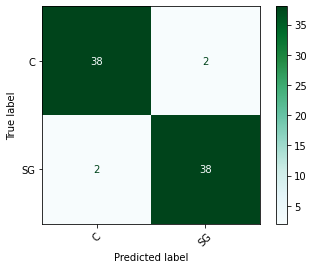

In [133]:
confusion_matrix2 = confusion_matrix(y_test1,pred1)
target_names = ["C","SG"]
disp = ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix2,
    display_labels = target_names
)
disp.plot(
    cmap=plt.cm.BuGn,
    xticks_rotation=45
)
plt.show()

3P : 3.4   
BLK : 0.5   
TRB : 3.7   
해당 선수의 적합한 포지션은?

In [136]:
print(knn.predict([[3.4,0.5,3.7]])) # Shooting Guard

['SG']
